In [1]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import theano

Populating the interactive namespace from numpy and matplotlib


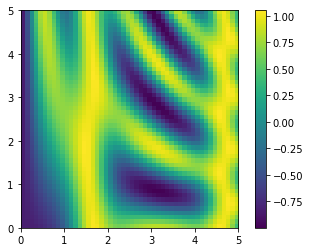

In [2]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5],
           cmap='viridis')
plt.colorbar();

In [13]:
def funz(z):
    z = z.T
    return tt.sin(z[0])**10 + tt.cos(10+z[0]*z[1]) * tt.cos(z[0])

z = tt.matrix('z')
z.tag.test_value = pm.floatX([[0., 0.]])
pot1f = theano.function([z], funz(z))

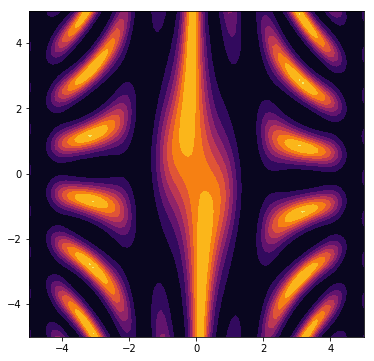

In [14]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title, fontsize=16)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
contour_pot(pot1f, ax);

In [15]:
from pymc3.distributions.dist_math import bound
def cust_logp(z):
    return bound(-funz(z), z>-5, z<5)
    #return -funz(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1f', logp=cust_logp, shape=(2,))
    trace = pm.sample(5000, step=pm.NUTS(),
                      njobs=2, start=[dict(pot1f=np.array([0, 0])),
                                      dict(pot1f=np.array([1, 2]))])

 55%|█████▍    | 3008/5500 [00:03<00:02, 896.56it/s] /home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.437923669208, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 2917 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 5472/5500 [00:05<00:00, 1271.14it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1235 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [00:05<00:00, 970.28it/s] 


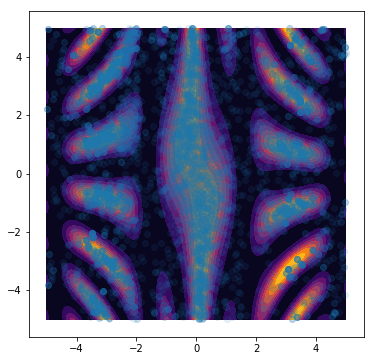

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
contour_pot(pot1f, ax)
dftrace = pm.trace_to_dataframe(trace)
ax.scatter(dftrace.iloc[:, 0], dftrace.iloc[:, 1], alpha=.1);

In [17]:
formula = 'planar*16'
def cust_logp(z):
    return bound(-funz(z), z>-5, z<5)
    #return -funz(z)

with pm.Model() as pot1m:
    pm.DensityDist('pot1f', logp=cust_logp, shape=(2,))
    inference = pm.NFVI(formula, jitter=0.1, start=dict(pot1f=np.array([3, 2])))

In [18]:
inference.fit(25000, obj_optimizer=pm.adam(learning_rate=0.1), obj_n_mc=100)
traceNF = inference.approx.sample(5000)

Average Loss = inf: 100%|██████████| 25000/25000 [01:44<00:00, 238.37it/s]
Finished [100%]: Average Loss = nan


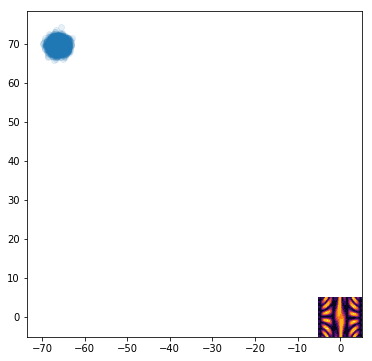

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
contour_pot(pot1f, ax)
dftrace = pm.trace_to_dataframe(traceNF)
ax.scatter(dftrace.iloc[:, 0], dftrace.iloc[:, 1], alpha=.1);

# GP

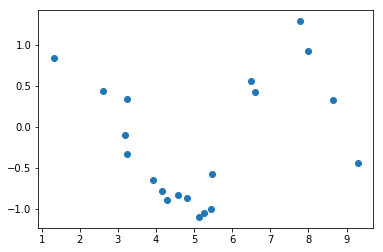

In [2]:
# generate noise less function sin(x) on a few random point
n = 20
ε = .2
X = np.random.rand(n, 1)*10
Y = np.sin(X) + np.random.randn(n, 1)*ε 
plt.scatter(X, Y);

In [ ]:
theta = tt.matrix('theta')
theta.tag.test_value = pm.floatX([[1.], [1.]])


In [82]:
# 1D Gaussian Process
theta = tt.matrix('theta')
theta.tag.test_value = pm.floatX([[1.], [1.]])
with pm.Model() as model:
    # hyperparameter
    # theta = pm.Flat('theta', shape=2)
    # covariance functions for the function f and the noise
    f_cov = pm.gp.cov.ExpQuad(1, tt.exp(theta[0]))

    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=tt.exp(theta[1]), observed={'X':X.T, 'Y':Y})

logp = y_obs.logpt
gp1 = theano.function([theta], logp)

In [83]:
from scipy import optimize
pm.find_MAP(model=model, fmin=optimize.fmin_l_bfgs_b)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Subtensor{int64}(theta, Constant{1}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-b266eae00158>", line 2, in <module>
    theta = tt.matrix('theta')


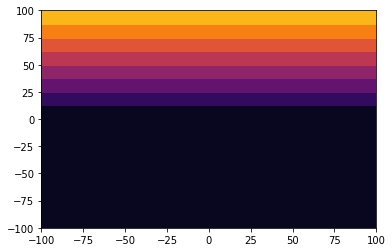

In [25]:
grid = pm.floatX(np.mgrid[-100:100:100j,-100:100:100j])
grid_2d = grid.reshape(2, -1)
cmap = plt.get_cmap('inferno')

pdf1e = np.asarray([(-gp1(grid_2d[:, i])) for i in range(grid_2d.shape[1])])
contour = plt.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [05:19<00:00,  1.45it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.998418983795, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 97 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



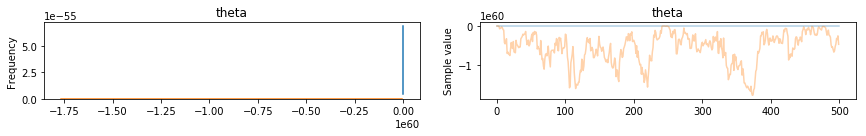

In [26]:
with model:
    tr = pm.sample()
pm.traceplot(tr);

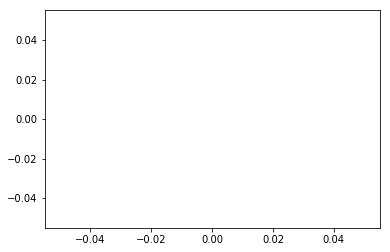

In [29]:
plt.scatter(np.exp(tr['theta'][:, 0]), np.exp(tr['theta'][:, 1]));

In [ ]:
# generate sin(x)+ε
n = 50
ε = .2
X = np.random.rand(n, 1)*10
Y = np.sin(X) + np.random.randn(n, 1)*ε
X1 = np.linspace(0, 10, 200)
Y1 = np.sin(X1)
plt.scatter(X, Y)
plt.plot(X1, Y1);